# Make Figure 5B:  Uniqueness of trans effect

Create a bar/dumbell plot to look at the number of genes that are significant in one or multiple cancers. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import cptac
import cptac.utils as u
import plot_utils as p

cptac warning: Your version of cptac (0.9.0) is out-of-date. Latest is 0.9.1. Please run 'pip install --upgrade cptac' to update it. (<ipython-input-1-47030fbe69b4>, line 7)


In [2]:
print('cptac version:', cptac.version())

cptac version: 0.9.0


# Step 1: Create sig column

The sig column names all cancers with a sig comparison for a protein. First, get a df with p-values and differential expressions for all proteins across all 8 cancers.

In [5]:
all_df = pd.read_csv("csv/all_proteins_pancan.csv")
all_df

,Umich_Proteomics,GBM_P_Value,GBM_Median,HNSCC_P_Value,HNSCC_Median,LUAD_P_Value,LUAD_Median,LSCC_P_Value,LSCC_Median,BR_P_Value,BR_Median,EC_P_Value,EC_Median
0,CUL2,4.572167e-07,-0.458427,0.492948,-0.012483,0.754037,-0.041117,0.061876,-0.161777,0.999518,0.019744,0.968884,0.006991
1,DOCK1_1,4.572167e-07,-0.358361,0.941940,-0.050514,0.823513,-0.061154,0.637861,-0.033188,NaN,0.223971,0.858479,0.106446
2,ATE1_1,2.291619e-06,-0.481942,0.112081,-0.118994,0.011157,-0.315236,0.000959,-0.209974,0.999518,-0.094422,0.859507,0.028872
3,GDI2,2.291619e-06,-0.486754,0.961669,-0.101908,0.838721,-0.006090,0.302531,-0.181925,0.999518,-0.041954,0.693008,0.052571
4,CUTC,2.291619e-06,-0.490992,0.043479,-0.384810,0.409869,-0.280224,0.008548,-0.231417,0.999518,0.067701,0.788035,0.020382
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16300,WDR38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.946308
16301,CFAP99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.273024
16302,MYO15A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.395354
16303,ZC3H11B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.245715


In [8]:
# create sig column values to show cancers with sig tests for each protein
for index, row in all_df.iterrows():
    cancer_names = ['GBM','HNSCC','LUAD','LSCC','BR','EC']
    label = []
    for cancer in cancer_names:
        if row[cancer+'_P_Value'] < 0.05:
            label.append(str(cancer))
    labeled = '_'.join(label)
    all_df.loc[index,'sig'] = str(labeled)
all_df[['Umich_Proteomics', 'sig']].head()

,Umich_Proteomics,sig
0,CUL2,GBM
1,DOCK1_1,GBM
2,ATE1_1,GBM_LUAD_LSCC
3,GDI2,GBM
4,CUTC,GBM_HNSCC_LSCC


# Step 2: Keep genes significant in at least one cancer

First create the numSig column that counts the number of cancers with a significant test for the specific gene. 

In [9]:
def Pvalue_sig(row):
    numSig = 0

    for item in row:
        if pd.isnull(item):
            continue
        if item < 0.05: 
            numSig += 1
            
    return numSig

In [24]:
# Create Num_sig column
all_df["Num_sig"] = all_df.loc[:,["GBM_P_Value","HNSCC_P_Value","LUAD_P_Value","LSCC_P_Value", "BR_P_Value","EC_P_Value"]].apply(Pvalue_sig, axis = 1)
all_df = all_df.sort_values(by=['Num_sig'],ascending=False)

#Keep trans genes that are significant in atleast 1 cancer. 
all_df1 = all_df[all_df['Num_sig'].isin([1,2,3,4,5,6,7,8])]
all_df1.head()
all_df1.sig.value_counts()

LSCC                 1154
GBM                   493
EC                    350
LSCC_EC               112
GBM_LSCC               75
HNSCC                  18
GBM_EC                 14
LUAD                   12
HNSCC_LSCC              7
GBM_LSCC_EC             6
GBM_HNSCC_LSCC          5
GBM_HNSCC               5
HNSCC_LSCC_EC           4
HNSCC_EC                2
GBM_HNSCC_LSCC_EC       2
GBM_LUAD                2
LUAD_LSCC               2
GBM_LUAD_LSCC           1
Name: sig, dtype: int64

In [32]:
all_df[['BR_P_Value']].value_counts() #.loc[all_df['BR_P_Value'] <= 0.5]

BR_P_Value
0.999518      8965
0.999584        15
0.759532         6
0.999644         4
0.999879         3
0.875617         1
0.902251         1
0.999839         1
dtype: int64

# Step 3: Get df with total counts of significant genes

Get count of sig genes for each unique label of a single cancer or multiple cancers in the sig column. 
* NOTE: Lscc has 3 significant genes that are also significnat in other cancers. They are only counted in the overlapping columns and Lscc alone shows 0 unique genes. (See columns: Gbm_Hnscc_Lscc, Gbm_Lscc, Luad_Lscc) 

In [37]:
# Count the number of unique values in sig
vc = all_df1['sig'].value_counts()
df = vc.to_frame()
df.index

Index(['LSCC', 'GBM', 'EC', 'LSCC_EC', 'GBM_LSCC', 'HNSCC', 'GBM_EC', 'LUAD',
       'HNSCC_LSCC', 'GBM_LSCC_EC', 'GBM_HNSCC_LSCC', 'GBM_HNSCC',
       'HNSCC_LSCC_EC', 'HNSCC_EC', 'GBM_HNSCC_LSCC_EC', 'GBM_LUAD',
       'LUAD_LSCC', 'GBM_LUAD_LSCC'],
      dtype='object')

In [38]:
# Add cancers with no significant genes.
no_sig = {'CO': 0, 'BR': 0, 'OV': 0}
ns_df = pd.DataFrame.from_dict(no_sig, orient = 'index', columns=['sig'])

# Append not sig cancers
both = df.append(ns_df)

# Reindex to keep single cancers together
ordered = ['GBM', 'HNSCC', 'EC', 'LUAD', 'LSCC', 'OV', 'BR', 'CO', 
           'LSCC_EC', 'GBM_LSCC', 'GBM_EC', 'HNSCC_LSCC', 'GBM_LSCC_EC', 
           'GBM_HNSCC_LSCC', 'GBM_HNSCC', 'HNSCC_LSCC_EC', 'HNSCC_EC',
           'GBM_HNSCC_LSCC_EC', 'GBM_LUAD', 'LUAD_LSCC', 'GBM_LUAD_LSCC']
           
both = both.reindex(ordered)

both = both.reset_index()
both = both.rename(columns = {'index': 'cancer'})
both

,cancer,sig
0,GBM,493
1,HNSCC,18
2,EC,350
3,LUAD,12
4,LSCC,1154
5,OV,0
6,BR,0
7,CO,0
8,LSCC_EC,112
9,GBM_LSCC,75


# Step 4: Create bar and dumbell plot

First, create a df with 4 y-axis points for the scatterplots. Values represent where the cancer label is on the y-axis. ('GBM': 7, 'HNSCC': 6, 'EC': 5, 'LUAD': 4, 'LSCC': 3, 'OV': 2, 'BR': 1, 'CO': 0) For a single cancer all 4 points are the same. For proteins that are significant in 4 cancers, each y-axis point represents a different cancer. NOTE: PTEN contains genes significant in up to 4 cancers.


In [39]:
# Create df with location of cancer points
y_points = {'GBM': 7, 'HNSCC': 6, 'EC': 5, 'LUAD': 4, 'LSCC': 3, 'OV': 2, 'BR': 1, 'CO': 0}
y1 = {}
y2 = {}
y3 = {}
y4 = {}

for c in ordered:
    c_list = c.split('_')
    num_sig = len(c_list)
    # Get first y point
    cancer1 = c_list[0]
    y1[c] = y_points[cancer1]
    
    # get other y points - combinations of y2, y3, y4 points are the same int when there are not 4 multiple cancers
    if num_sig == 1:
        y2[c] = y_points[cancer1]
        y3[c] = y_points[cancer1]
        y4[c] = y_points[cancer1]
    
    if num_sig == 2:
        cancer2 = c_list[1]
        y2[c] = y_points[cancer2]
        y3[c] = y_points[cancer2]
        y4[c] = y_points[cancer2]
    
    if num_sig == 3 :
        cancer2 = c_list[1]
        cancer3 = c_list[2]
        y2[c] = y_points[cancer2]
        y3[c] = y_points[cancer3]
        y4[c] = y_points[cancer3]
        
    if num_sig == 4:
        cancer2 = c_list[1]
        cancer3 = c_list[2]
        cancer4 = c_list[3]
        y2[c] = y_points[cancer2]
        y3[c] = y_points[cancer3]
        y4[c] = y_points[cancer4]

In [40]:
# Create df with location of cancer points 
     
# Create dfs for each y-axis point
y1_df = pd.DataFrame.from_dict(y1, orient = 'index', columns=['y1'])
y2_df = pd.DataFrame.from_dict(y2, orient = 'index', columns=['y2'])
y3_df = pd.DataFrame.from_dict(y3, orient = 'index', columns=['y3'])
y4_df = pd.DataFrame.from_dict(y4, orient = 'index', columns=['y4'])

# Join dfs
y_points_df = y1_df.join(y2_df)
y_points_df = y_points_df.join(y3_df)
y_points_df = y_points_df.join(y4_df)
y_points_df

# Reindex to keep single cancers together
y_points_df = y_points_df.reindex(ordered)
y_points_df

,y1,y2,y3,y4
GBM,7,7,7,7
HNSCC,6,6,6,6
EC,5,5,5,5
LUAD,4,4,4,4
LSCC,3,3,3,3
OV,2,2,2,2
BR,1,1,1,1
CO,0,0,0,0
LSCC_EC,3,5,5,5
GBM_LSCC,7,3,3,3


Create bar plot and dumbell plot. x-axis of dumbell plot follows order of bar plot. 

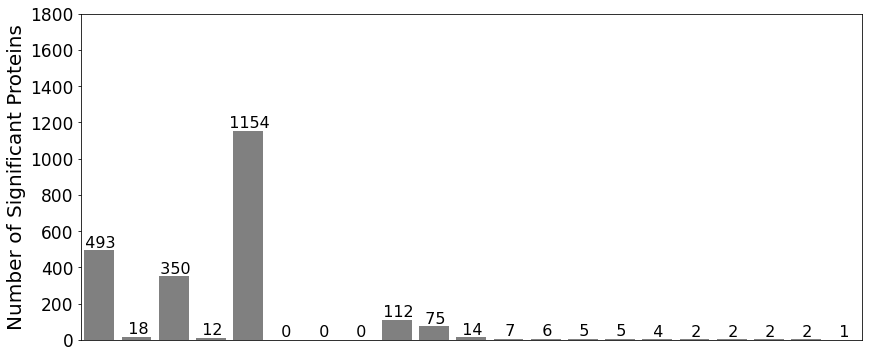

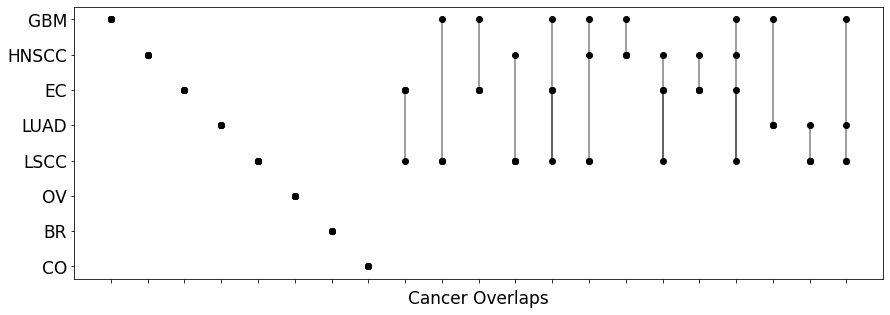

In [41]:
# Bar Plot
plt.figure(figsize=(14,6))
o = sns.barplot(x=both['cancer'], y=both['sig'], data=both, color='grey')
plt.setp(o.get_xticklabels(),rotation=90)

# Annotate count of sig genes above each bar
for p in o.patches:
    o.annotate('  {:.0f}'.format(p.get_height()), xy = (p.get_x()+0.3, p.get_height()),
                    ha='center', va='bottom', color= 'black',size = 16)

o.set(ylim=(0, 1800))
o.set_xlabel('', size = 17)
o.set_ylabel('Number of Significant Proteins', size = 20)
o.get_xaxis().set_visible(False) # Hide x-axis
o.yaxis.set_tick_params(labelsize=17)



# Dumbell Plot
# Create vertical dumbell plot using scatterplots
plt.rcParams.update({'font.size': 17})
d = plt.figure(figsize=(14.5,5))
my_range=range(1,len(y_points_df.index)+1) #range count for x axis num
d = plt.vlines(x=my_range, ymin=y_points_df['y1'], ymax=y_points_df['y2'], color='black', alpha=0.5) #vertical lines
d = plt.vlines(x=my_range, ymin=y_points_df['y2'], ymax=y_points_df['y3'], color='black', alpha=0.5)
d = plt.vlines(x=my_range, ymin=y_points_df['y3'], ymax=y_points_df['y4'], color='black', alpha=0.5)

d = plt.scatter(my_range, y_points_df['y1'], color='black', alpha=1) #plots first point
d = plt.scatter(my_range, y_points_df['y2'], color='black', alpha=1) # plots second point
d = plt.scatter(my_range, y_points_df['y3'], color='black', alpha=1) # plots third point
d = plt.scatter(my_range, y_points_df['y4'], color='black', alpha=1) # plots fourth point

# Add title and axis names
labels = list(y_points_df.index[:8]) # label 8 single cancer names y axis
labels.reverse()
plt.xticks(my_range, []) #none for x axis
plt.yticks(range(0,8), labels) # single cancer names
#plt.ylabel('Cancer')
plt.xlabel('Cancer Overlaps')

o.figure.savefig("Fig_5B_1.png", dpi = 300)
d.figure.savefig("Fig_5B_2.png", dpi = 300)

# Get total number of proteins significant in at least one cancer

In [17]:
#Keep proteins that are significant in at least 1 cancer. 
total = all_df[all_df['Num_sig'].isin([1,2,3,4,5,6,7,8])]
total_count = len(total.Umich_Proteomics.unique())
print('Total significant proteins in at least one cancer:', total_count)

Total significant proteins in at least one cancer: 2264


# Calculate percentage of proteins significant in only one cancer

In [19]:
#Keep proteins that are significant in 1 cancer. 
one = all_df[all_df['Num_sig'].isin([1])]
one_count = len(one.Umich_Proteomics.unique())
print('Significant proteins in only one cancer:', one_count)
print('Percent:', one_count / total_count * 100)

Significant proteins in only one cancer: 2027
Percent: 89.53180212014135


# Calculate percentage of proteins significant in multiple cancers

In [20]:
#Keep proteins that are significant in multiple cancers. 
mult = all_df[all_df['Num_sig'].isin([2,3])]
mult_count = len(mult.Umich_Proteomics.unique())
print('Significant proteins in multiple cancers:', mult_count)
print('Percent:', mult_count / total_count * 100)

Significant proteins in multiple cancers: 235
Percent: 10.379858657243817


In [21]:
#Keep proteins that are significant in 3 cancers. 
three = all_df[all_df['Num_sig'].isin([3])]
three_count = len(three.Umich_Proteomics.unique())
print('Significant proteins in 3 cancers:', three_count)
print('Percent:', three_count / total_count * 100)

Significant proteins in 3 cancers: 16
Percent: 0.7067137809187279


In [22]:
#Keep proteins that are significant in 4 cancers. 
four = all_df[all_df['Num_sig'].isin([4])]
four_count = len(four.Umich_Proteomics.unique())
print('Significant proteins in 4 cancers:', four_count)
print('Percent:', four_count / total_count * 100)

Significant proteins in 4 cancers: 2
Percent: 0.08833922261484099
